# Parallelism Demo

Consider a function, $f$,

$$f(t) = \sum_{k\in\mathbb{N}}^{\infty}(-1)^k\dfrac{\sin[(2k+1) x]}{(2k+1)^2}$$

<img src='images/fourier.jpeg' width=150 style="display:block;margin-left:auto;margin-right:auto;width:50%;"/>

> All vibes may be approximated by harmonic oscillators

In [1]:
import hellaPy
from plt_style import *
import numpy as np
import pylab as plt
import scipy as sp


In [2]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                128
On-line CPU(s) list:   0-127
Thread(s) per core:    1
Core(s) per socket:    64
Socket(s):             2
NUMA node(s):          8
Vendor ID:             AuthenticAMD
CPU family:            25
Model:                 1
Model name:            AMD EPYC 7713 64-Core Processor
Stepping:              1
CPU MHz:               1996.161
BogoMIPS:              3992.32
Virtualization:        AMD-V
L1d cache:             32K
L1i cache:             32K
L2 cache:              512K
L3 cache:              32768K
NUMA node0 CPU(s):     0-15
NUMA node1 CPU(s):     16-31
NUMA node2 CPU(s):     32-47
NUMA node3 CPU(s):     48-63
NUMA node4 CPU(s):     64-79
NUMA node5 CPU(s):     80-95
NUMA node6 CPU(s):     96-111
NUMA node7 CPU(s):     112-127
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall n

In [3]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           1.5T         25G        1.2T        3.9G        219G        1.4T
Swap:           31G        378M         31G


In [3]:
N = 10**7#2**20+1
t = np.linspace(0,10*np.pi,N)[:-1]
f = np.array([ (-1)**k*np.sin(ell*t)/ell**2 for k,ell in enumerate(2*np.arange(31)+1) ]).sum(axis=0)

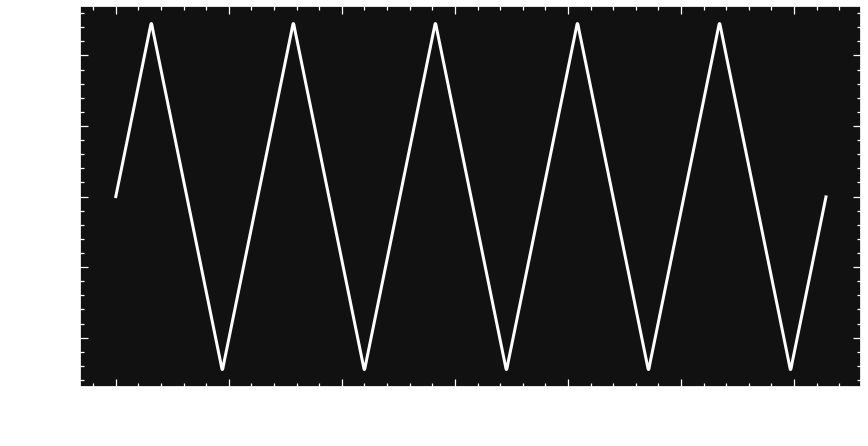

In [4]:
skip  = 1000
ts,fs= [ u[::skip] for u in [t,f] ]
plt.figure(figsize=(14,7))
plt.plot(ts,fs,'w-',lw=3)
_=plt.xticks(fontsize=20)
_=plt.yticks(fontsize=20)
_=plt.xlabel(r'$t$',fontsize=20,color='w')
_=plt.ylabel(r'$f(t)$',fontsize=20,color='w')

In [5]:
%%time
#hellaPy.mkl_set_num_threads(1)
q = abs(np.fft.fft(f)[:len(t)//2])

CPU times: user 2.33 s, sys: 526 ms, total: 2.85 s
Wall time: 2.85 s


In [7]:
%%time
hellaPy.mkl_set_num_threads(2)
q = abs(np.fft.fft(f)[:len(t)//2])

MKL THREADS SET: 2
CPU times: user 2.56 s, sys: 175 ms, total: 2.74 s
Wall time: 2.74 s


In [ ]:
%%time
hellaPy.mkl_set_num_threads(4)
q = abs(np.fft.fft(f)[:len(t)//2])

In [ ]:
%%time
hellaPy.mkl_set_num_threads(8)
q = abs(np.fft.fft(f)[:len(t)//2])

In [ ]:
%%time
hellaPy.mkl_set_num_threads(16)
q = abs(np.fft.fft(f)[:len(t)//2])

In [ ]:
%%time
hellaPy.mkl_set_num_threads(32)
q = abs(np.fft.fft(f)[:len(t)//2])

In [ ]:
!uptime

In [6]:
tau = 10*np.pi
om0 = 2*np.pi/tau
om  = om0*np.arange(len(q))
p   = q/q.max()
k   = np.linspace(1,11,1001)

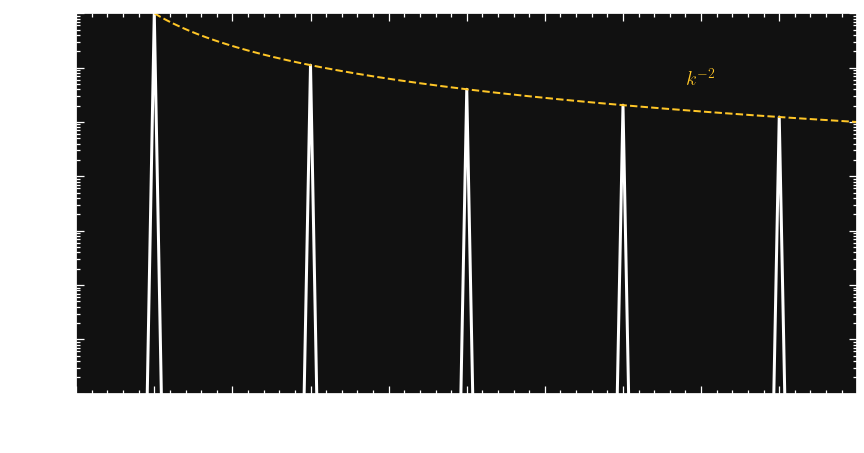

In [7]:
plt.figure(figsize=(14,7))
plt.semilogy(om,p,'w-',lw=3)
plt.semilogy(k,1/k**2,'--',c=gld,lw=2)
plt.annotate(r'$k^{-2}$',(8,5e-2),fontsize=20,color=gld,ha='center')
_=plt.xlim(0,10)
_=plt.ylim(1e-7,1)
_=plt.xticks(np.arange(10),fontsize=20)
_=plt.yticks(fontsize=20)
_=plt.xlabel(r'$\omega$',fontsize=20,color='w')
_=plt.ylabel(r'$PSD$',fontsize=20,color='w')

## Einsum On the CPU

Consider 

$$U(x,y,z) = \sum_{\ell\in\mathbb{N}\,odd}^{\infty}\dfrac{\cos(\ell x)\sin(\ell z)}{\ell^3}$$

for $(x,y,z)\in[0,\pi]^3$. Then, in the $xz$-plane, $\partial U/\partial x$ is the cartesian product of two orthogonal triangle waves.

In [ ]:
import cheb

In [ ]:
N = 256
Do,xo = cheb.cheb(N)
D,x = Do*2/np.pi,(xo+1)*np.pi/2
sanity = np.isclose( (D@x).sum()/(N+1),1)
print(f"Sanity: {sanity.__repr__():s}")

In [ ]:
X,Y,Z = np.meshgrid(x,x,x,indexing='ij')
U = np.array([ np.cos(ell*X)*np.sin(ell*Z)/ell**3 for ell in 2*np.arange(31)+1 ]).sum(axis=0)

In [ ]:
hellaPy.mkl_set_num_threads(40)

In [ ]:
%%time
dUdx = np.einsum('ij,jkl->ikl',D,U)

In [ ]:
dUdx_iter = 0*dUdx

In [ ]:
%%time
for k in range(U.shape[-1]):
    dUdx_iter[:,:,k] = D @ U[:,:,k]

In [ ]:
f,a = hellaPy.no_ax_fax()
L   = np.abs(dUdx).max() * np.linspace(-1,1,16)
hellaPy.mycontourf(X[:,128,:],Z[:,128,:],dUdx[:,128,:],L,cmap=hellaPy.mycm15)